In [14]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [15]:
start_day_to_analyze = '2020-04-15'
end_day_to_analyze = '2020-04-16'

In [16]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [17]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [18]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [19]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [20]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,1722,374,CEMI,sell,147,9.95,"{'rsi': 48.74397372001454, 'reasons': 'below c...",2020-04-15T15:15:10.754251496Z,2020-04-15 15:15:10.934155,9.75,11.07
1,1721,374,SRS,buy,284,19.67,"{'rsi': 65.65027798756445, 'macd': [0.07366135...",2020-04-15T14:18:04.594561606Z,2020-04-15 14:18:05.159612,19.33,20.73
2,1723,374,SRS,sell,284,19.60,"{'rsi': 35.41225220126659, 'reasons': 'below c...",2020-04-15T15:30:37.53805985Z,2020-04-15 15:30:37.744269,19.33,20.73
3,1710,373,TECS,sell_short,24,4.09,"{'rsi': 99.71000690280692, 'macd': [0.00657800...",2020-04-15T13:50:45.790324675Z,2020-04-15 13:50:45.909083,4.11,0.41
4,1711,373,TECS,buy_short,24,4.13,"{'rsi': [61.11484644233459, 99.85476868382761,...",2020-04-15T13:53:00.320097492Z,2020-04-15 13:53:00.545085,4.11,0.41
5,1712,373,TECS,sell_short,24,4.11,"{'rsi': 98.73166619597615, 'macd': [0.69795595...",2020-04-15T13:55:14.675322131Z,2020-04-15 13:55:15.211807,4.12,0.41
6,1713,373,TECS,buy_short,24,4.12,"{'rsi': [99.4217568908344, 99.42749624578275, ...",2020-04-15T13:55:16.454047369Z,2020-04-15 13:55:16.538836,4.12,0.41
7,1714,373,TECS,sell_short,24,4.11,"{'rsi': 98.73094053115612, 'macd': [0.69795595...",2020-04-15T13:55:21.671448123Z,2020-04-15 13:55:21.805140,4.12,0.41
8,1715,373,TECS,buy_short,24,4.12,"{'rsi': [99.4217568908344, 99.42749624578275, ...",2020-04-15T13:55:22.496211924Z,2020-04-15 13:55:22.596154,4.12,0.41
9,1716,373,TECS,sell_short,24,4.11,"{'rsi': 98.7317179974229, 'macd': [0.697955958...",2020-04-15T13:55:26.74129727Z,2020-04-15 13:55:26.917157,4.12,0.41


In [21]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [22]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'sell_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [23]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
26,373,momentum_short,PAPER,v0.1-286-g596e899,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-15 13:49:01.431249,None,None


,symbol,count,revenue
0,TECS,10,-2.16


TOTAL REVENUE: -2.16 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
27,374,momentum_long,PAPER,v0.1-286-g596e899,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-15 13:49:01.578624,None,None


,symbol,count,revenue
0,WORX,2,-32.50
1,SRS,2,-19.88
2,CEMI,1,1462.65


TOTAL REVENUE: 1410.27 $


In [24]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [25]:
minute_history['TECS']

,open,high,low,close,volume
timestamp,,,,,
2020-04-06 04:00:00-04:00,0.5510,0.551,0.5510,0.5510,16060.0
2020-04-06 07:00:00-04:00,0.5470,0.548,0.5320,0.5480,24150.0
2020-04-06 07:03:00-04:00,0.5550,0.555,0.5550,0.5550,1200.0
2020-04-06 07:07:00-04:00,0.5540,0.554,0.5540,0.5540,10000.0
2020-04-06 07:25:00-04:00,0.5540,0.554,0.5500,0.5500,13190.0
...,...,...,...,...,...
2020-04-14 10:21:00-04:00,0.3900,0.390,0.3898,0.3900,93580.0
2020-04-14 10:22:00-04:00,0.3890,0.389,0.3880,0.3880,81180.0
2020-04-14 10:23:00-04:00,0.3883,0.389,0.3880,0.3890,39710.0


In [13]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

TECS analysis for run 373 with profit 2.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-98.16,-98.16,sell_short,2020-04-15 13:50:45.909083,4.09,None,None,24,"{'rsi': 99.71000690280692, 'macd': [0.006578006308900042, 0.00652827045965082, 0.006255363222094856, 0.30072809557760405, 0.5276143890689278], 'stop_price': 4.105, 'macd_signal': [0.005860059860591948, 0.005993701980403722, 0.0060460342287419495, 0.06498244649851437, 0.15750883501259705], 'target_price': 0.407, 'distance_to_stop': 0.001219512195122142}",0.41,4.11
1,0.96,99.12,buy_short,2020-04-15 13:53:00.545085,4.13,None,None,24,"{'rsi': [61.11484644233459, 99.85476868382761, 99.42173888750362, 99.4217568908344, 99.42749624578275], 'reasons': 'stopped', 'movement': 0.004878048780487918}",0.41,4.11
2,-97.68,-98.64,sell_short,2020-04-15 13:55:15.211807,4.11,None,None,24,"{'rsi': 98.73166619597615, 'macd': [0.697955958349999, 0.8264707188578846, 0.9161450102089872, 0.9767679449118853, 1.0139150539251318], 'stop_price': 4.12, 'macd_signal': [0.2654706243524421, 0.3776706432535306, 0.4853655166446219, 0.5836460022980746, 0.6696998126234861], 'target_price': 0.407, 'distance_to_stop': 2.4272433796880247e-05}",0.41,4.12
3,1.20,98.88,buy_short,2020-04-15 13:55:16.538836,4.12,None,None,24,"{'rsi': [99.4217568908344, 99.42749624578275, 98.72165257346686, 98.72656904452293, 98.7317179974229], 'reasons': 'stopped', 'movement': 2.4272433796880247e-05}",0.41,4.12
4,-97.44,-98.64,sell_short,2020-04-15 13:55:21.805140,4.11,None,None,24,"{'rsi': 98.73094053115612, 'macd': [0.697955958349999, 0.8264707188578846, 0.9161450102089872, 0.9767679449118853, 1.0138033730134508], 'stop_price': 4.12, 'macd_signal': [0.2654706243524421, 0.3776706432535306, 0.4853655166446219, 0.5836460022980746, 0.6696774764411498], 'target_price': 0.407, 'distance_to_stop': 0.0003642102707296484}",0.41,4.12
5,1.44,98.88,buy_short,2020-04-15 13:55:22.596154,4.12,None,None,24,"{'rsi': [99.4217568908344, 99.42749624578275, 98.72165257346686, 98.72656904452293, 98.7317179974229], 'reasons': 'stopped', 'movement': 0.0003642102707296484}",0.41,4.12
6,-97.20,-98.64,sell_short,2020-04-15 13:55:26.917157,4.11,None,None,24,"{'rsi': 98.7317179974229, 'macd': [0.697955958349999, 0.8264707188578846, 0.9161450102089872, 0.9767679449118853, 1.0139230311331087], 'stop_price': 4.12, 'macd_signal': [0.2654706243524421, 0.3776706432535306, 0.4853655166446219, 0.5836460022980746, 0.6697014080650814], 'target_price': 0.407, 'distance_to_stop': 0.0}",0.41,4.12
7,1.68,98.88,buy_short,2020-04-15 13:55:38.362549,4.12,None,None,24,"{'rsi': [99.4217568908344, 99.42749624578275, 98.72165257346686, 98.72656904452293, 98.7317179974229], 'reasons': 'stopped', 'movement': 0.0}",0.41,4.12
8,-96.96,-98.64,sell_short,2020-04-15 13:55:41.023141,4.11,None,None,24,"{'rsi': 98.7317179974229, 'macd': [0.697955958349999, 0.8264707188578846, 0.9161450102089872, 0.9767679449118853, 1.0139230311331087], 'stop_price': 4.12, 'macd_signal': [0.2654706243524421, 0.3776706432535306, 0.4853655166446219, 0.5836460022980746, 0.6697014080650814], 'target_price': 0.407, 'distance_to_stop': 0.0}",0.41,4.12
9,2.16,99.12,buy_short,2020-04-15 13:56:01.438555,4.13,None,None,24,"{'rsi': [99.4217568908344, 99.42749624578275, 98.72165257346686, 98.72656904452293, 98.7317179974229], 'reasons': 'stopped', 'movement': 0.0}",0.41,4.12


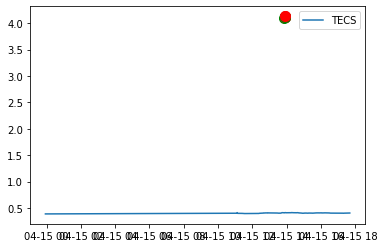

now=2020-04-15 10:18:05.159612
timestamp
2020-04-14 15:35:00-04:00    18.2300
2020-04-14 15:40:00-04:00    18.3000
2020-04-14 15:45:00-04:00    18.2500
2020-04-14 15:50:00-04:00    18.1999
2020-04-14 15:55:00-04:00    18.2600
2020-04-14 16:25:00-04:00    18.0500
2020-04-14 17:40:00-04:00    17.8400
2020-04-15 04:00:00-04:00    18.6400
2020-04-15 08:20:00-04:00    19.0000
2020-04-15 08:30:00-04:00    19.0600
Name: close, dtype: float64
timestamp
2020-04-14 14:00:00-04:00    18.230
2020-04-14 14:05:00-04:00    18.330
2020-04-14 14:10:00-04:00    18.280
2020-04-14 14:15:00-04:00    18.250
2020-04-14 14:20:00-04:00    18.130
2020-04-14 14:25:00-04:00    18.150
2020-04-14 14:30:00-04:00    18.230
2020-04-14 14:35:00-04:00    18.220
2020-04-14 14:40:00-04:00    18.235
2020-04-14 14:45:00-04:00    18.210
Name: close, dtype: float64
timestamp
2020-04-14 12:00:00-04:00    18.3400
2020-04-14 12:05:00-04:00    18.3200
2020-04-14 12:10:00-04:00    18.3600
2020-04-14 12:15:00-04:00    18.3100
2020-

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5586.28,-5586.28,buy,2020-04-15 14:18:05.159612,19.67,"[17.84, 18.175, 18.98, 19.0, 19.2, 19.335, 19.34]","[20.13, 20.46, 20.46, 20.46, 20.64, 20.65, 21.13]",284,"{'rsi': 65.65027798756445, 'macd': [0.07366135180604871, 0.06741590646259255, 0.07052940761558091, 0.08492853920136412, 0.09603978429904103], 'sell_macd': [0.03515173590913889, 0.03151820013402329, 0.03399183199583078, 0.043789573290798245, 0.051374961659725216], 'slow macd': [0.1620387723647525, 0.15972011532715058, 0.15909072296216564, 0.16081619488392462, 0.16230641723995376], 'macd_signal': [0.10882443220656089, 0.10054272705776722, 0.09454006316932996, 0.0926177583757368, 0.09330216356039764], 'resistances': [20.13, 20.46, 20.46, 20.46, 20.64, 20.65, 21.13], 'sell_macd_signal': [0.05694078455875829, 0.05185626767381129, 0.04828338053821519, 0.0473846190887318, 0.048182687602930485]}",20.73,19.33
1,-19.88,5566.40,sell,2020-04-15 15:30:37.744269,19.60,None,None,284,"{'rsi': 35.41225220126659, 'reasons': 'below cost & macd negative', 'movement': -0.002032520325203209, 'sell_macd': [0.005318908290888658, 0.0017848502734558735, -0.0020311020813394975, -0.004458712980127899, -0.012006738187231747], 'sell_macd_signal': [0.0025002096598908596, 0.0023571377826038624, 0.0014794898098151902, 0.00029184925182657224, -0.0021678682359850916]}",20.73,19.33


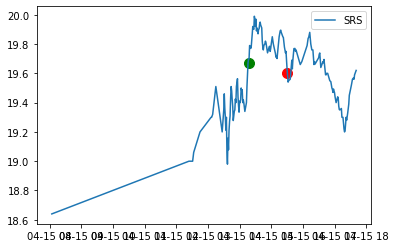

now=2020-04-15 09:50:21.591582
Series([], Freq: 5T, Name: close, dtype: float64)
timestamp
2020-04-15 09:10:00-04:00    8.920
2020-04-15 09:15:00-04:00    9.070
2020-04-15 09:20:00-04:00    9.020
2020-04-15 09:25:00-04:00    8.890
2020-04-15 09:30:00-04:00    8.635
2020-04-15 09:35:00-04:00    9.670
2020-04-15 09:40:00-04:00    9.389
2020-04-15 09:45:00-04:00    9.700
Freq: 5T, Name: close, dtype: float64
timestamp
2020-04-15 08:00:00-04:00    8.81
2020-04-15 08:05:00-04:00    8.81
2020-04-15 08:10:00-04:00    8.80
2020-04-15 08:15:00-04:00    8.61
2020-04-15 08:20:00-04:00    8.75
2020-04-15 08:25:00-04:00    8.75
2020-04-15 08:30:00-04:00    8.72
2020-04-15 08:35:00-04:00    8.51
2020-04-15 08:40:00-04:00    8.50
2020-04-15 08:45:00-04:00    8.50
Freq: 5T, Name: close, dtype: float64
timestamp
2020-04-15 05:25:00-04:00    7.99
2020-04-15 05:50:00-04:00    7.99
2020-04-15 06:20:00-04:00    8.01
2020-04-15 06:55:00-04:00    8.05
2020-04-15 07:00:00-04:00    8.35
2020-04-15 07:05:00-04:

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-630.5,-630.5,buy,2020-04-15 13:50:21.591582,9.7,"[8.253, 8.8, 9.11]","[10.08, 10.64, 10.9799]",65,"{'rsi': 64.22948603415279, 'macd': [0.23589134418699587, 0.2506314843503432, 0.24973522397290537, 0.2597482937743667, 0.26862180095472077], 'sell_macd': [0.14816474448011796, 0.15683063260936514, 0.15530235540346382, 0.16092574517284675, 0.1658150651857042], 'slow macd': [0.06429130499101454, 0.07416034354428547, 0.08119913456263639, 0.090264093217165, 0.09925946046674561], 'macd_signal': [0.19414269789730748, 0.20544045518791462, 0.21429940894491278, 0.22338918591080356, 0.232435708919587], 'resistances': [10.08], 'sell_macd_signal': [0.12448098649974242, 0.13095091572166695, 0.13582120365802633, 0.14084211196099042, 0.14583670260593318]}",14.28,8.24
1,-32.5,598.0,sell,2020-04-15 14:07:05.863833,9.2,None,None,65,"{'rsi': 44.320903804449074, 'reasons': 'below cost & macd negative', 'movement': -0.055384615384615296, 'sell_macd': [0.04356584731507063, 0.03868615032348721, 0.022952800066104118, 0.009096257007543684, -0.0015594422200031488], 'sell_macd_signal': [0.08452372451604291, 0.07535620967753177, 0.06487552775524624, 0.05371967360570573, 0.04266385044056396]}",14.28,8.24


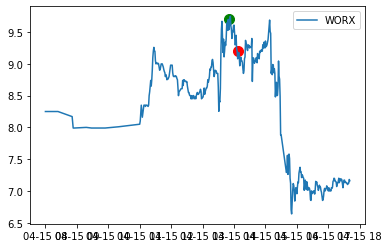

CEMI analysis for run 374 with profit 1462.65


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,1462.65,1462.65,sell,2020-04-15 15:15:10.934155,9.95,None,None,147,"{'rsi': 48.74397372001454, 'reasons': 'below cost & macd negative', 'movement': -0.012896825396825474, 'sell_macd': [0.007630254874376519, 0.005921085212394317, 0.0037331467067929225, 0.0017719849270143584, -9.08941861492707e-05], 'sell_macd_signal': [0.02754494530873247, 0.02322017328946484, 0.019322767972930456, 0.015812611363747238, 0.012631910253767937]}",11.07,9.75


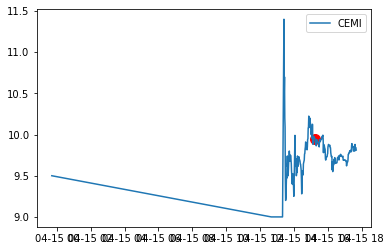

In [22]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

